In [1]:
# From https://idiotdeveloper.com/unet-segmentation-with-pretrained-mobilenetv2-as-encoder/
%load_ext autoreload
%autoreload 2
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"
DATAPATH = '../../ufz_im_challenge/photos_annotated'
import sys
sys.path.insert(0,'../')

from src.utils.kerasDataLoader import DataGenerator
import src.utils.keras_losses as Loss

import numpy as np
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, MaxPooling2D
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2, mobilenet_v2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Recall, Precision

from tensorflow.keras import backend as K
import numpy as np

IMAGESIZE = (224, 224)

/p/software/jusuf/stages/Devel-2019a/software/TensorFlow/1.13.1-GCCcore-8.3.0-GPU-Python-3.6.8/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/p/software/jusuf/stages/Devel-2019a/software/TensorFlow/1.13.1-GCCcore-8.3.0-GPU-Python-3.6.8/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/p/software/jusuf/stages/Devel-2019a/software/TensorFlow/1.13.1-GCCcore-8.3.0-GPU-Python-3.6.8/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated;

In [2]:
if os.path.isfile('models/weights/mobilenetweights.h5'):
    MODELPATH = 'models/weights/mobilenetweights.h5'
else:
    if not os.path.isdir('models/weights/'):
        os.makedirs('models/weights/')
    mobilenet = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    mobilenet.save_weights('models/weights/mobilenetweights.h5')
    MODELPATH = 'models/weights/mobilenetweights.h5'

In [3]:
try:
    from albumentations import (
        HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
        Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
        IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
        IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
    )

    def augmentations(p=0.5):
        return Compose([
            Flip(),
            OneOf([
                GaussNoise(),
            ], p=0.2),
            OneOf([
                MotionBlur(p=0.2),
                MedianBlur(blur_limit=3, p=0.1),
                Blur(blur_limit=3, p=0.1),
            ], p=0.2),
            OneOf([
                CLAHE(clip_limit=2),
                IAASharpen(),
                IAAEmboss(),
                RandomBrightnessContrast(),
            ], p=0.3),
            HueSaturationValue(p=0.3),
        ], p=p)
    
except:
        augmentations = None


In [4]:
def make_model(image_size, n_classes = 22, MODELPATH=MODELPATH):
    inputs = Input(shape=(*image_size, 3), name='input_image')
   
    encoder = MobileNetV2(input_tensor=inputs, weights=MODELPATH, include_top=False, alpha=1.0)
    skip_connection_names = ["input_image", 
                             "block_1_expand_relu", 
                             "block_3_expand_relu", 
                             "block_6_expand_relu"]
    
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [32, 64, 128, 256]
    x = encoder_output
    
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

   # x = tf.keras.layers.Dropout(0.25)(x)
        
    x = Conv2D(n_classes, (1, 1), padding="same")(x)
    x = tf.keras.layers.Softmax(axis=-1)(x)
    
    model = Model(inputs, x)
    return model

In [5]:
Loss.BCE_dice

<function src.utils.keras_losses.BCE_dice(y_true, y_pred)>

In [6]:
model = make_model(image_size=IMAGESIZE,)

opt = tf.keras.optimizers.Adam(0.1)

metrics = [Loss.dice_coef, tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
model.compile(loss=Loss.BCE_dice, optimizer=opt, metrics=metrics)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False, verbose=0),
    ModelCheckpoint('models/kerasUnet2', monitor='val_loss', verbose=1, save_best_only=False)
]

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
train_dataset = DataGenerator(datapath= DATAPATH,  batch_size=32, shuffle=True, augmentation=augmentations, preprocessing=mobilenet_v2.preprocess_input, image_size=IMAGESIZE)
valid_dataset = DataGenerator(datapath= DATAPATH, step='valid', shuffle=False, preprocessing=mobilenet_v2.preprocess_input, image_size=IMAGESIZE)

In [8]:
model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=120,
    callbacks=callbacks
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/120
83/83 [==============================] - 2s 26ms/step - loss: 1.8112 - dice_coef: 0.6971 - recall: 0.6971 - precision: 0.6971

Epoch 00001: saving model to models/kerasUnet2
20/20 [==============================] - 36s 2s/step - loss: 23.5407 - dice_coef: 0.5562 - recall: 0.5217 - precision: 0.8167 - val_loss: 1.8112 - val_dice_coef: 0.6971 - val_recall: 0.6971 - val_precision: 0.6971
Epoch 2/120
83/83 [==============================] - 1s 12ms/step - loss: 1.8112 - dice_coef: 0.6971 - recall: 0.6971 - precision: 0.6971

Epoch 00002: saving model to models/kerasUnet2
20/20 [==============================] - 8s 377ms/step - loss: 17.6741 - dice_coef: 0.6443 - recall: 0.6042 - precision: 0.8749 - val_loss: 1.8112 - val_dice_coef: 0.6971 - val_recall: 0.6971 - val_precision: 0.6971
Epoch 3/120
83/83 [==============================] - 1s 12ms/step - loss: 1.8112 - dice_coef: 0.6971 - recall: 0.6971 - precision: 0.6971

Epoch 00003

In [9]:
test_dataset = DataGenerator(datapath= DATAPATH, step='test', shuffle=False, preprocessing=mobilenet_v2.preprocess_input, image_size=IMAGESIZE)

In [10]:
pred = model.predict(test_dataset)

In [11]:
model.evaluate(test_dataset)

83/83 [==============================] - 1s 13ms/step - loss: 1.8621 - dice_coef: 0.6848 - recall: 0.6848 - precision: 0.6848


[1.8620900475835225, 0.68477786, 0.68478256, 0.6847847]

In [12]:
x = test_dataset.images
y = test_dataset.labels

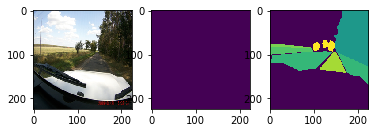

In [13]:
viz_idx = 7
plt.subplot(131)
plt.imshow(x[viz_idx].squeeze())
plt.subplot(132)
plt.imshow(np.argmax(pred[viz_idx], -1).squeeze())
plt.subplot(133)
plt.imshow(np.argmax(y[viz_idx], -1).squeeze())


In [14]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=metrics)
model.save('models/final_keras')